In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [3]:
! kaggle competitions download playground-series-s3e24
! mkdir /content/data
! unzip playground-series-s3e24.zip -d /content/data

  0% 0.00/6.81M [00:00<?, ?B/s]
100% 6.81M/6.81M [00:00<00:00, 87.9MB/s]
Archive:  playground-series-s3e24.zip
  inflating: /content/data/sample_submission.csv  
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


In [26]:
train_dataset  = '/content/data/train.csv'
train = pd.read_csv(train_dataset)

# Зниження розмірності і візуалізація даних

In [29]:
train = train.dropna()
train = train.drop('id', axis=1)

columns_to_normalize = [ 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp']


scaler = MinMaxScaler()
train[columns_to_normalize] = scaler.fit_transform(train[columns_to_normalize])

target_column = 'hearing(left)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

target_column = 'hearing(right)'
train[target_column].replace({1: 0, 2: 1}, inplace=True)

In [30]:
y = train['smoking']
X = train.drop('smoking', axis=1)

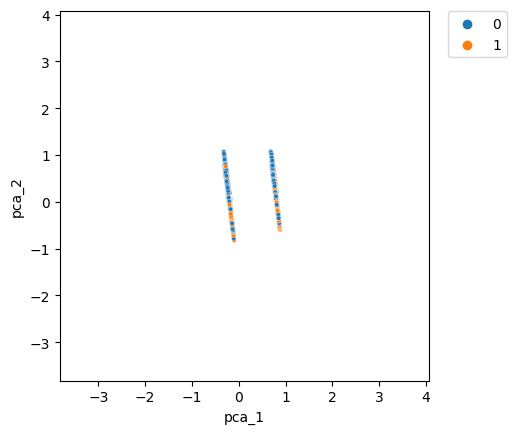

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-3, pca_result.max()+3)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


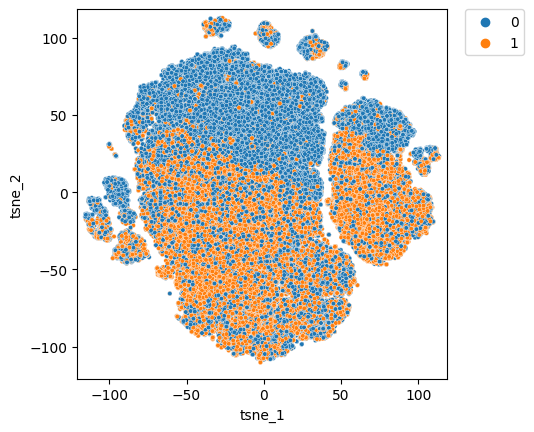

In [33]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

# Кластерний аналіз

In [42]:
from PIL import Image

In [56]:
def load_custom_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img_array = np.array(img)

    return img_array


custom_image_path = "/content/data/img.jpg"
img = load_custom_image(custom_image_path)

In [57]:



img = np.array(img, dtype=np.float64) / 255


w, h, d = original_shape = tuple(img.shape)
assert d == 3
image_array = np.reshape(img, (w * h, d))



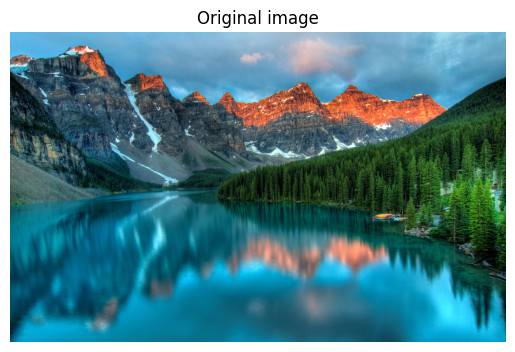

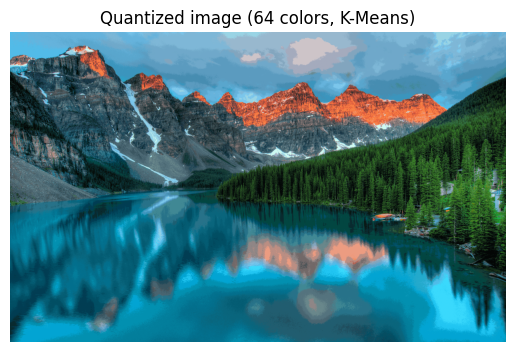

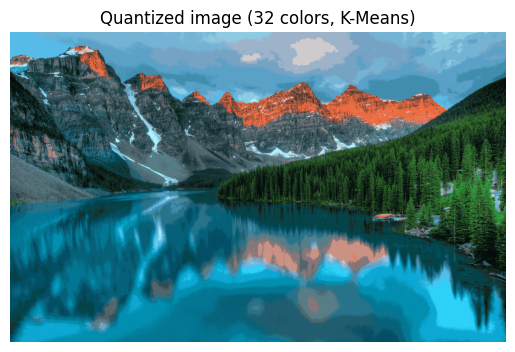

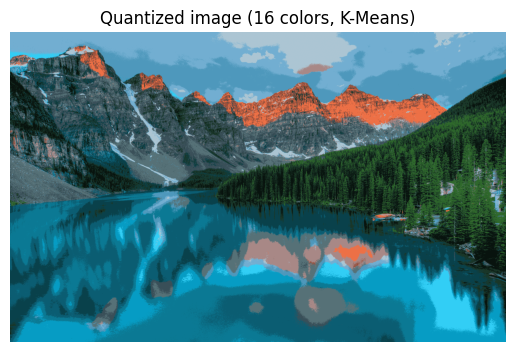

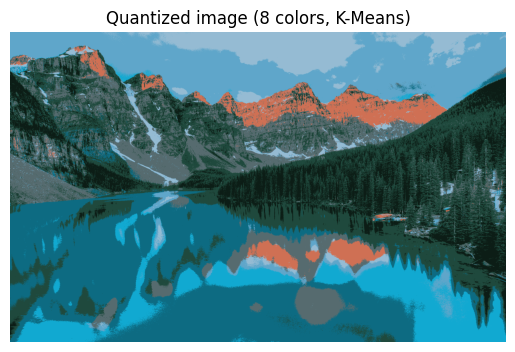

In [63]:

def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)


plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(img)

n_cols = [64,32,16,8]
for n_colors in n_cols:
  image_array = np.reshape(img, (w * h, d))
  image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
  kmeans = KMeans(n_clusters=n_colors, n_init="auto", random_state=0).fit(image_array_sample)
  labels = kmeans.predict(image_array)
  plt.figure(2)
  plt.clf()
  plt.axis("off")
  plt.title(f"Quantized image ({n_colors} colors, K-Means)")
  plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
  plt.show()



# Обробка та класифікація текстових даних

In [150]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import string
import re

In [67]:

! kaggle datasets download subhajournal/phishingemails
! unzip phishingemails.zip -d /content/data

phishingemails.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  phishingemails.zip
  inflating: /content/data/Phishing_Email.csv  


In [143]:
train_text_dataset  = '/content/data/Phishing_Email.csv'
train_2 = pd.read_csv(train_text_dataset)

In [144]:
print(train_2.shape)
print(train_2.columns)
print(train_2.head())
print(train_2.nunique())

(18650, 3)
Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
Unnamed: 0    18650
Email Text    17537
Email Type        2
dtype: int64


In [145]:
train_2 = train_2.drop('Unnamed: 0',axis=1)
train_2 = train_2.dropna()
train_2  = train_2.drop_duplicates(subset=['Email Text'])

In [146]:
print(train_2.shape)
print(train_2.columns)
print(train_2.head())
print(train_2.nunique())

(17537, 2)
Index(['Email Text', 'Email Type'], dtype='object')
                                          Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email
Email Text    17537
Email Type        2
dtype: int64


In [155]:
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation))
def clean_text(text):
  text = re.sub("https*\S+", " ", text)
  text = re.sub("@\S+", " ", text)
  text = re.sub("#\S+", " ", text)
  text = re.sub("\d", " ", text)
  text = re.sub('\n', " ", text)
  return text

In [156]:
train_2['Email Text'] = train_2['Email Text'].apply(remove_punctuation)
train_2['Email Text'] = train_2['Email Text'].str.lower()
train_2['Email Text'] = train_2['Email Text'].apply(clean_text)

In [157]:
print(train_2.head())

                                          Email Text      Email Type
0  re           disc  uniformitarianism  re      ...      Safe Email
1  the other side of  galicismos   galicismo  is ...      Safe Email
2  re  equistar deal tickets are you still availa...      Safe Email
3   hello i am your hot lil horny toy     i am th...  Phishing Email
4  software at incredibly low prices      lower  ...  Phishing Email


In [158]:
target_column = 'Email Type'
train_2[target_column].replace({'Safe Email': 0, 'Phishing Email': 1}, inplace=True)


In [159]:
y_2 = train_2['Email Type']
X_2 = train_2['Email Text']
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [ ]:
text_classifier = Pipeline([
    ('tfidvectorizer',TfidfVectorizer()),
    ('LinearSVC',LinearSVC())
])

text_classifier.fit(X_train_2,y_train_2)



In [161]:
y_pred_2 = text_classifier.predict(X_valid_2)
predictions = [round(value) for value in y_pred_2]

accuracy = accuracy_score(y_valid_2, predictions)
print(classification_report(y_valid_2, predictions))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
confusion_matrix_2 = confusion_matrix(y_valid_2, predictions)
print(confusion_matrix_2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2194
           1       0.98      0.98      0.98      1314

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508

Accuracy: 98.43%
[[2169   25]
 [  30 1284]]


In [162]:
text = X_2.to_list()
text = ' '.join(text).lower()
wordcloud = WordCloud(width=800, height=400, max_words=150, background_color='white').generate(text)

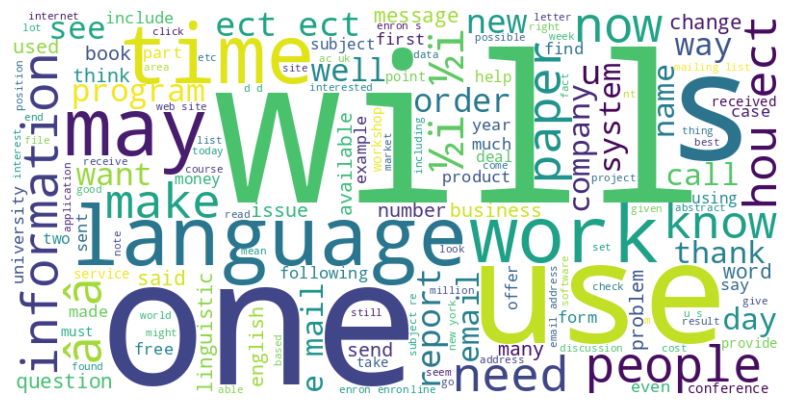

In [163]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()